# Neural Network from Scratch

Our objective is to build a neural network for the classification of the MNIST dataset.
*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28. We will be importing this dataset using keras.

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

 This neural network will comprise of: an output layer with 10 nodes, a hidden layer of 256 nodes, and an input layer with 784 nodes corresponding to the image pixels. The specific structure of the neural network is outlined below, where $X$ represents the input, $A^{[0]}$ denotes the first layer, $Z^{[1]}$ signifies the unactivated layer 1, $A^{[1]}$ stands for the activated layer 1, and so forth. The weights and biases are represented by $W$ and $b$ respectively:

<div align="center">

$A^{[0]}=X$

$Z^{[1]}=W^{[1]}A^{[0]}+b^{[1]}$

$A^{[1]}=\text{ReLU}(Z^{[1]})$

$Z^{[2]}=W^{[2]}A^{[1]}+b^{[2]}$

$A^{[2]}=\text{softmax}(Z^{[2]})$

$Loss=\text{cross-entropy-loss}(A^{[2]})$
</div>

## Getting Started

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
mnist = tf.keras.datasets.mnist
import matplotlib.pyplot as plt

### Implementation of the activation function(ReLU) and softmax function

* Use ReLU for the hidden layer and Softmax function for the output layer for classification into 10 different neurons, each corresponding to a particular number between $1$ and $10$


In [2]:
def ReLU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

### Define the NN class

In [3]:
class NN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # initialized basic stats of NN
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.learning_rate=learning_rate

        #initialized weights and biases
        self.W1=np.random.randn(hidden_size, input_size)*0.01
        self.B1= np.zeros((1,hidden_size))
        self.W2=np.random.randn(output_size, hidden_size)*0.01
        self.B2=np.zeros((1,output_size))

        #initialized activations and gradients
        self.AO=None
        self.Z1=None
        self.A1=None
        self.Z2=None
        self.A2=None
        self.dZ2=None
        self.dW2=None
        self.dB2=None
        self.dZ1=None
        self.dW1=None
        self.dB1=None

    # do the forward pass and evaluate the values of A0, Z1, A1, Z2, A2
    def forward_propagation(self, X):
        self.Z1 = np.dot(X, self.W1.T) + self.B1
        self.A1 = ReLU(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2.T) + self.B2
        self.A2 = softmax(self.Z2)

        forward_data = {
            "Z1" : self.Z1,
            "Z2" : self.Z2,
            "A1" : self.A1,
            "A2" : self.A2
        }
        return forward_data
    
    # convert the input y, into a one hot encoded array.
    '''
    one hot encoding is:
    you have an array with values [2, 5, 6] and you know the max value can be 8, then one hot encoded array will be:
    [[0,0,1,0,0,0,0,0,0], [0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0]]
    Note that the index 2, 5, 6 have values 1 and all others have values 0
    '''
    def one_hot(self, y):
        one_hot_y = np.zeros((y.size, self.output_size))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y

    # calculate the derivative of the cost function with respect to W2, B2, W1, B1 in dW2, dB2, dW1, dB1 respectively
    def backward_propagation(self, X, y):
         m = X.shape[0]
         y_one_hot = self.one_hot(y)

        # Gradients for output layer
         self.dZ2 = self.A2 - y_one_hot
         self.dW2 = np.dot(self.dZ2.T, self.A1) / m
         self.dB2 = np.sum(self.dZ2, axis=0, keepdims=True) / m

        # Gradients for hidden layer
         self.dA1 = np.dot(self.dZ2, self.W2)
         self.dZ1 = self.dA1 * (self.Z1 > 0)  # Derivative of ReLU
         self.dW1 = np.dot(self.dZ1.T, X) / m
         self.dB1 = np.sum(self.dZ1, axis=0, keepdims=True) / m
    
    # update the parameters W1, W2, B1, B2
    def update_params(self):
        self.W1 -= self.learning_rate * self.dW1
        self.B1 -= self.learning_rate * self.dB1
        self.W2 -= self.learning_rate * self.dW2
        self.B2 -= self.learning_rate * self.dB2
    
    # get the predictions for the dataset
    def get_predictions(self,X):
        forward_data = self.forward_propagation(X)
        predictions = np.argmax(forward_data["A2"], axis=1)
        return predictions

    # get the accuracy of the model on the dataset
    # (after the gradient descent has been run separately)
    def get_accuracy(self, X, y):
        predictions = self.get_predictions(X)
        return np.mean(predictions == y)
    
    # run gradient descent on the model to get the values of the parameters
    def gradient_descent(self, X, y, iters=1000):
        for i in range(iters):
            self.forward_propagation(X)
            self.backward_propagation(X, y)
            self.update_params()

            if i % 100 == 0:
                loss = self.cross_entropy_loss(y)
                accuracy = self.get_accuracy(X, y)
                print(f"Iteration {i}: Loss = {loss}, Accuracy = {accuracy}")

            
    
    # evaluate cost using cross-entropy-loss formula.
    def cross_entropy_loss(self, y):
        m = y.size  # Number of samples
        y_one_hot = self.one_hot(y)  # Convert y to one-hot encoding
        log_likelihood = -np.sum(y_one_hot * np.log(self.A2 + 1e-9))  # Add small value for numerical stability
        return log_likelihood / m

    # Function for random outputs to get an intuitive feel
    def show_predictions(self, X, y, num_samples=10):
        random_indices = np.random.randint(0, X.shape[0], size=num_samples)

        for index in random_indices:
            sample_image = X[index, :].reshape((28, 28))
            plt.imshow(sample_image, cmap='gray')
            plt.title(f"Actual: {y[index]}, Predicted: {self.get_predictions(X[index])}")
            plt.show()

### Prepare the data

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

miu = np.mean(X_train, axis=(0, 1), keepdims=True)
stds = np.std(X_train, axis=(0, 1), keepdims=True)

mius = np.mean(X_test, axis=(0, 1), keepdims=True)
stdse = np.std(X_test, axis=(0, 1), keepdims=True)

X_normal_train = (X_train - miu) / (stds + 1e-7)
X_normal_test = (X_test - mius) / (stdse + 1e-7)

X_normal_train = X_normal_train.reshape((60000, -1))
X_normal_test = X_normal_test.reshape((10000, -1))

### Train the model
* Train the model on X_normal_train and Y_train_dataset
* Print the accuracy on X_normal_test and Y_test_dataset

In [5]:
# Initialise the model as an instance of the NN class and train it
input_size = 784  # Each image is 28x28 pixels
hidden_size = 256  # Hidden layer with 256 nodes
output_size = 10   # Output layer for 10 classes (digits 0-9)
learning_rate = 0.01

model = NN(input_size, hidden_size, output_size, learning_rate)

# Train the neural network
print("Training the model...")
model.gradient_descent(X_normal_train, Y_train, iters=1000)

# Evaluate the model
accuracy = model.get_accuracy(X_normal_test, Y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Training the model...
Iteration 0: Loss = 2.302698318351416, Accuracy = 0.15278333333333333
Iteration 100: Loss = 2.0253187729569766, Accuracy = 0.55525
Iteration 200: Loss = 1.383623032511058, Accuracy = 0.7329333333333333
Iteration 300: Loss = 0.8757139625937812, Accuracy = 0.8089
Iteration 400: Loss = 0.6541172432414204, Accuracy = 0.8461333333333333
Iteration 500: Loss = 0.5418742893694347, Accuracy = 0.8665833333333334
Iteration 600: Loss = 0.4748604999132123, Accuracy = 0.8796
Iteration 700: Loss = 0.4306807614031729, Accuracy = 0.8882166666666667
Iteration 800: Loss = 0.39956970389175545, Accuracy = 0.89415
Iteration 900: Loss = 0.3765238579972599, Accuracy = 0.89805
Test Accuracy: 90.48%


Visualizing predictions


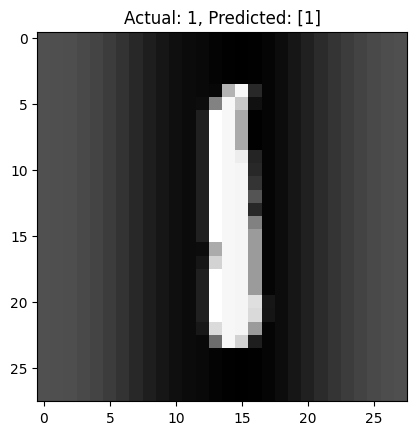

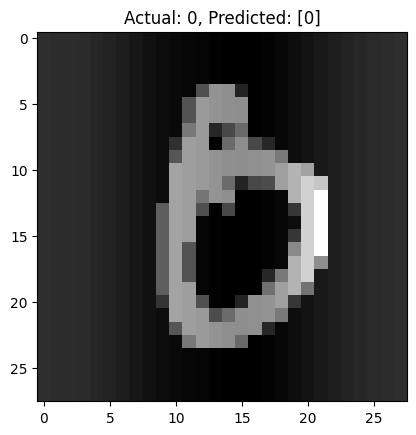

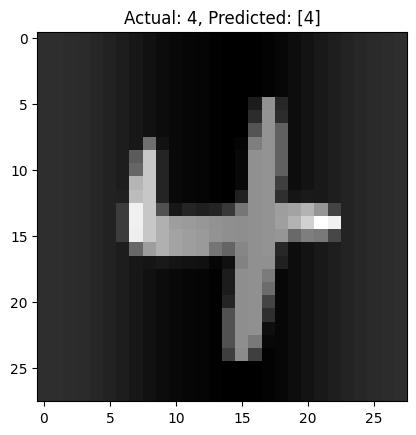

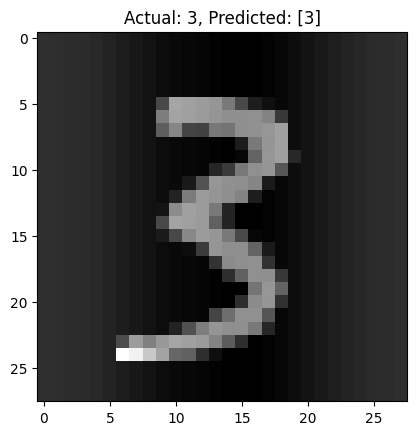

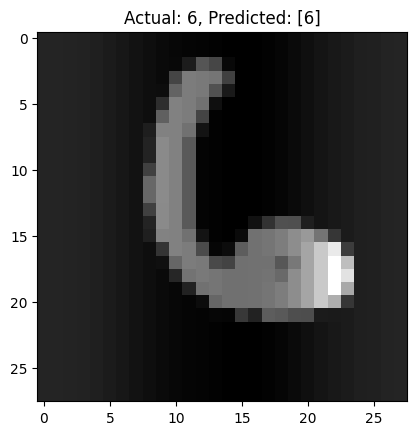

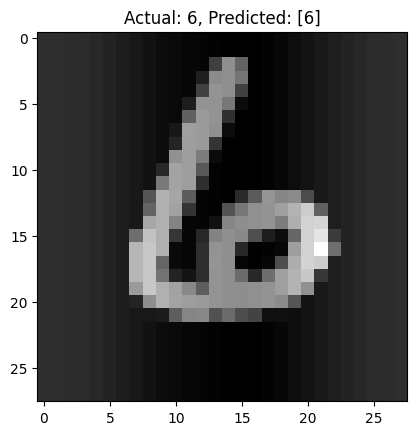

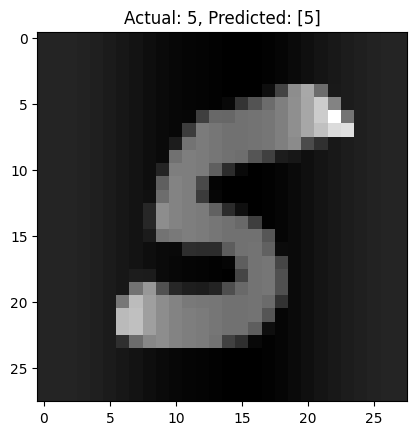

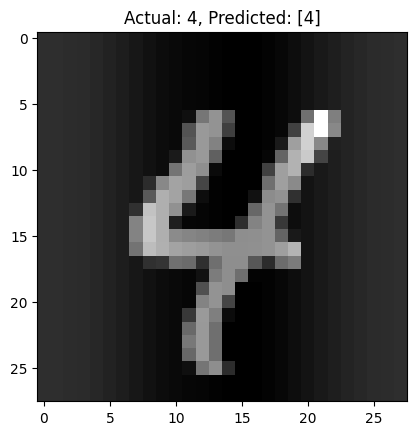

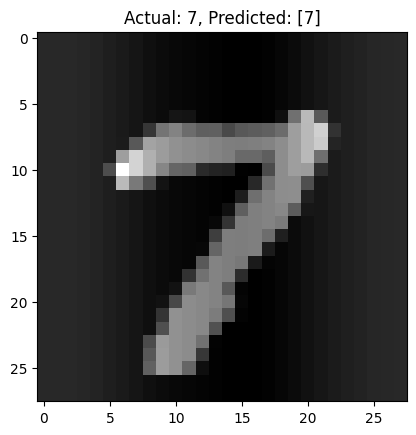

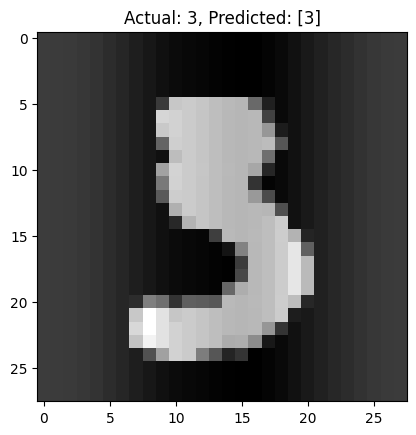

In [6]:
# Use the show_predictions function to print the actual output and see your model work :)
# Visualize predictions
print("Visualizing predictions")
model.show_predictions(X_normal_test, Y_test, num_samples=10)